In [30]:
import tensorflow as tf

import time
import matplotlib.pyplot as plt
import IPython.display as display

## Load and prepare the dataset

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # normalize the image to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the model

### The generator

In [7]:
def make_generator_model():
    model = tf.keras.Sequential([
        # iput
        tf.keras.layers.Input(shape=[100, ]),

        # pass to dense layer to reform the image shape
        tf.keras.layers.Dense(7 * 7 * 256, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.3),
        tf.keras.layers.Reshape((7, 7, 256)), # output shape: [None, 7, 7, 256]

        # Conv2DTranspose layers stack
        tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.3), # output shape: [None, 7, 7, 128]

        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.3), # output shape: [None, 14, 14, 64]
        
        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'),
        # output shape: [None, 28, 28, 1]
    ])
    return model

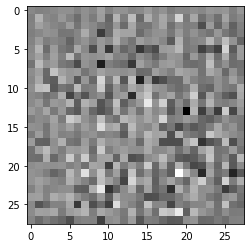

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        # Input
        tf.keras.layers.Input(shape=[28, 28, 1]),

        # Conv2D layers stacks
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(0.3),
        tf.keras.layers.Dropout(0.3), # output shape: [None, 14, 14, 64]
        
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(0.3),
        tf.keras.layers.Dropout(0.3), # output shape: [None, 7, 7, 128]
        
        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    
    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00056013]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

### Discriminator loss

In [17]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator should be able to distinguish real images and fake images.
    Args:
        real_logits: logits output from discriminator, when feed in real images.
          Expected softmax(real_logits) == 1
        fake_logits: logits output from discriminator, when feed in fake images.
          Expected softmax(fake_logits) == 0
    """
    # real image score should be compare with 1s
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_logits), real_logits)
    # fake image score should be compare with 0s
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [18]:
def generator_loss(fake_logits):
    """Generator should be able to generate fake images looks like real.
    Args:
        fake_logits: logits output from discriminator, when feed in fake image.
          Expected softmax(fake_logits) == 1
    """
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_logits), fake_logits)

### Optimizers

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [21]:
checkpoint_dir = './training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           generator=generator,
                           discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

## Define the training loop

In [26]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will resue this seed overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [38]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_logits = discriminator(images, training=True)
        fake_logtis = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_logtis)
        disc_loss = discriminator_loss(real_logits, fake_logtis)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def generate_and_show_image(generator, test_input):
    generated_images = generator(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    # for each generated_image in batch, batch_size is 16 in test_input
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.show()

In [34]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_show_image(generator, seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint_manager.save()
            
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

## Train the model

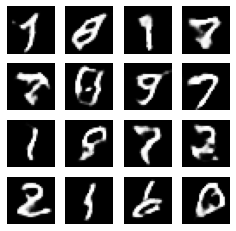

Time for epoch 49 is 11.133935689926147 sec


In [39]:
train(train_dataset, EPOCHS)